# About
This notebook uses a siamese network which compares a pair of pictures. It determines if the pair of pictures are of the same person or of different people

In [ ]:
# download images
!wget https://www.kaggle.com/varump66/face-images-13233/downloads/face-images-13233.zip
!unzip face-images-13233.zip

In [3]:
import shutil
from os import listdir
from os.path import isfile, join
import os
import random
### generate train and validation set ###
split_ratio = 0.7 # ratio of train to val (ie. value of 0.7 equates to 70% in train and 30% in val)

mypath = 'Images'
files = [os.path.join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

train_path = 'Images_train'
val_path = 'Images_val'

# clear directories and copy files into train and validation folders based on split_ratio
shutil.rmtree(train_path) 
shutil.rmtree(val_path) 
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

train_files = random.sample(files, k=int(len(files) * split_ratio ) )
test_files = list(set(files) - set(train_files))

_ = [shutil.copy(f, os.path.join(train_path, os.path.basename(f))) for f in train_files]
_ = [shutil.copy(f, os.path.join(val_path, os.path.basename(f))) for f in test_files]

In [4]:
import re
import os

def get_name_from_path(image_path):
    """
    extract name from image path
    
    >>> image_path = 'Orlando_Bloom_0001.jpg'
    >>> get_name_from_path(image_path)
    >>> Orlando_Bloom
    """
    name = re.findall(r'(.*?)_[0-9][0-9][0-9][0-9].jpg' , image_path)
    name = name[0]
    
    return os.path.basename(name)

image_path = 'Orlando_Bloom_0001.jpg'
get_name_from_path(image_path)

'Orlando_Bloom'

In [6]:
# get filenames from path
mypath = 'Images'
files = [os.path.join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
data = [(f, get_name_from_path(f) ) for f in files]
data[:10]

[('Images/Sean_Penn_0001.jpg', 'Sean_Penn'),
 ('Images/Sam_Brownback_0001.jpg', 'Sam_Brownback'),
 ('Images/George_W_Bush_0105.jpg', 'George_W_Bush'),
 ('Images/Ashanti_0005.jpg', 'Ashanti'),
 ('Images/Tony_Blair_0040.jpg', 'Tony_Blair'),
 ('Images/Tim_Conway_0002.jpg', 'Tim_Conway'),
 ('Images/Naomi_Watts_0021.jpg', 'Naomi_Watts'),
 ('Images/Carla_Del_Ponte_0002.jpg', 'Carla_Del_Ponte'),
 ('Images/Dan_Prinster_0001.jpg', 'Dan_Prinster'),
 ('Images/Lionel_Richie_0002.jpg', 'Lionel_Richie')]

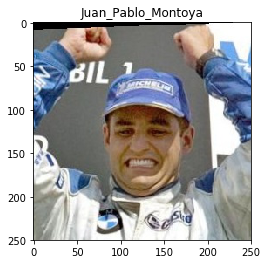

In [8]:
import matplotlib.pyplot as plt
import random

# plot a random face
def plot_face(path, name):
    plt.figure()
    plt.imshow(plt.imread(path))
    plt.title(os.path.basename(name) )
    
idx = random.randint(0, len(data))
plot_face(data[idx][0], data[idx][1])

In [9]:
# convert images to arrays
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def convert_img_to_array(img_path):
    img = load_img(img_path)  # this is a PIL image
    return img_to_array(img)

data = [(f, n, convert_img_to_array(f) ) for f, n in data]
data[:1]

Using TensorFlow backend.


[('Images/Sean_Penn_0001.jpg', 'Sean_Penn', array([[[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ...,
          [ 1.,  0.,  4.],
          [ 2.,  0.,  5.],
          [ 2.,  0.,  3.]],
  
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ...,
          [ 1.,  0.,  4.],
          [ 1.,  0.,  4.],
          [ 1.,  0.,  2.]],
  
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ...,
          [ 1.,  0.,  5.],
          [ 1.,  0.,  4.],
          [ 1.,  0.,  2.]],
  
         ...,
  
         [[ 1.,  0.,  0.],
          [ 1.,  0.,  0.],
          [ 0.,  0.,  0.],
          ...,
          [83., 84., 66.],
          [68., 67., 49.],
          [48., 47., 29.]],
  
         [[ 1.,  0.,  0.],
          [ 1.,  0.,  0.],
          [ 0.,  0.,  0.],
          ...,
          [67., 68., 50.],
          [52., 51., 33.],
          [41., 40., 22.]],
  
         [[ 1.,  0.,  0.],
         

In [10]:
import numpy as np

def generate_batch(data, batch_size):
    """
    generate pairs of faces, where 1/2 pairs are of different face and 1/2 pairs are of same face
    
    Args:
        data (list): has format [(img_path(str), name(str), img (np.array)), ... ]
        batch_size (int): number of samples within batch
        
    Returns:
        x1 (np.array): array of 1st image
        x2 (np.array): array of 2nd image
        y (np.array): 2-dim array of whether images are of same person or different person
                    [1,0] indicates faces are different, [0,1] indicates faces are same
    """
    x1 = []
    x2 = []
    y = []
    
    ### generate batch where pair are of different people's face ###
    num_diff_samples = batch_size // 2
        
    for i in range(0,num_diff_samples):
        # get random sample
        path1, name1, array1 = random.choice(data) 
        x1.append(array1)
        
        filtered_data = [(path, name, arr) for path,name,arr in data if name != name1]
        
        # get random sample from filtered_data
        path2, name2, array2 = random.choice(filtered_data) 
        x2.append(array2)
        y.append(np.array((0,1)))
    
    ### generate batch where pair is same person's face ###
    num_same_samples = batch_size - num_diff_samples
    
    for i in range(0,num_diff_samples):
        # get random sample
        path1, name1, array1 = random.choice(data) 
        x1.append(array1)
        
        filtered_data = [(path, name, arr) for path,name,arr in data if name == name1]
        
        # get random sample from filtered_data
        path2, name2, array2 = random.choice(filtered_data) 
        x2.append(array2)
        y.append(np.array((1,0)))

    x1 = np.stack(x1)
    x2 = np.stack(x2)
    y = np.vstack(y)
    
    return x1, x2, y

def generate_data(data, batch_size):    
    while True:
        x1, x2, y = generate_batch(data, batch_size)
        yield ([x1, x2], y)
        
x1,x2,y = generate_batch(data, 4)
y

array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0]])

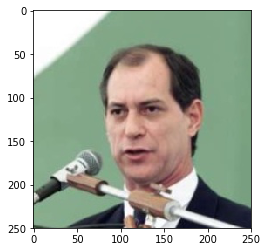

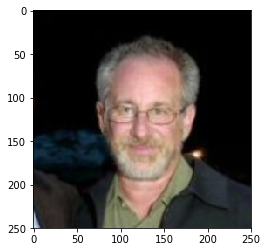

In [13]:
# verify generate_batch is correct (idx 0 and idx 1 should be of different people and idx 2 and 3 should be of same person)
idx = 0

plt.figure()
plt.imshow(x1[idx]/255)
plt.figure()
plt.imshow(x2[idx]/255)

In [18]:
# generate siamese network
# create model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Add, Subtract
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import clear_session
from keras import backend as K
from keras.optimizers import Adam
# from keras.preprocessing import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rescale=1./250,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)


clear_session()

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = data[0][2].shape

input_l = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
input_r = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

### generate encoder model ###
encoder_input = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
encoder_input_norm = Lambda(lambda x: x / 255.) (encoder_input)
mp1 = MaxPooling2D(pool_size=(4, 4), strides=None, padding='valid', data_format=None) (encoder_input)

c1 = Conv2D(32, (3,3), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (mp1)
c1 = BatchNormalization()(c1)
c1 = Conv2D(32, (3,3), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (c1)
c1 = BatchNormalization()(c1)
c1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) (c1)


c2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (c1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(64, (3,3), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (c2)
c2 = BatchNormalization()(c2)
c2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) (c2)

c3 = Conv2D(128, (3,3), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (c2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(128, (3,3), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (c3)
c3 = BatchNormalization()(c3)
c3 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None) (c3)
c3 = Conv2D(1, (1,1), strides=(1, 1), padding='same', 
            data_format=None, dilation_rate=(1, 1), activation='relu', 
            use_bias=True, kernel_initializer='glorot_uniform', 
            bias_initializer='zeros', kernel_regularizer=None, 
            bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
            bias_constraint=None) (c3)

encoder_output = BatchNormalization()(c3)
encoder = Model(inputs=[encoder_input], outputs=[encoder_output])

encoded_l = encoder(input_l)
encoded_r = encoder(input_r)
flattenl = Flatten() (encoded_l)
flattenr = Flatten() (encoded_r)
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# L1_distance = L1_layer([encoded_l, encoded_r])
# concat = Concatenate(axis=-1)([flattenl, flattenr])
distance = Subtract() ([flattenl,flattenr])
abs_distance = Lambda(lambda x: K.abs(x)) (distance)
d1 = Dense(4096, activation='softmax') (abs_distance)
outputs = Dense(2, activation='softmax') (d1)


model = Model(inputs=[input_l, input_r], outputs=[outputs])

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 7, 7, 1)      288933      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 49)           0           model_1[1][0]                    
__________

In [19]:
import math
batch_size = 16

# get training and validation data
mypath = 'Images_train'
files = [os.path.join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
data_train = [(f, get_name_from_path(f) ) for f in files]
data_train = [(f, n, convert_img_to_array(f) ) for f, n in data_train]

mypath = 'Images_val'
files = [os.path.join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
data_val = [(f, get_name_from_path(f) ) for f in files]
data_val = [(f, n, convert_img_to_array(f) ) for f, n in data_val]


earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
steps_per_epoch = math.ceil(len(data_train) // batch_size)
validation_steps = math.ceil(len(data_val)// batch_size)

model.fit_generator(generate_data(data_train, batch_size), epochs=50, 
                    callbacks=[earlystopper, checkpointer], 
                    validation_data=generate_data(data_val, batch_size) ,
                    validation_steps=validation_steps ,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/50
578/578 [==============================] - 42s 72ms/step - loss: 0.6321 - binary_accuracy: 0.7446 - val_loss: 0.5705 - val_binary_accuracy: 0.8019

Epoch 00001: val_loss improved from inf to 0.57052, saving model to model-dsbowl2018-1.h5
Epoch 2/50
578/578 [==============================] - 38s 66ms/step - loss: 0.5753 - binary_accuracy: 0.7715 - val_loss: 0.5482 - val_binary_accuracy: 0.8133

Epoch 00002: val_loss improved from 0.57052 to 0.54815, saving model to model-dsbowl2018-1.h5
Epoch 3/50
578/578 [==============================] - 38s 65ms/step - loss: 0.5531 - binary_accuracy: 0.7856 - val_loss: 0.5225 - val_binary_accuracy: 0.8271

Epoch 00003: val_loss improved from 0.54815 to 0.52251, saving model to model-dsbowl2018-1.h5
Epoch 4/50
578/578 [==============================] - 38s 65ms/step - loss: 0.5389 - binary_accuracy: 0.7961 - val_loss: 0.5209 - val_binary_accuracy: 0.8173

Epoch 00004: val_loss improved from 0.52251 to 0.52088, saving model to model-dsbowl20

KeyboardInterrupt: 

array([[0.36933056, 0.6306695 ]], dtype=float32)

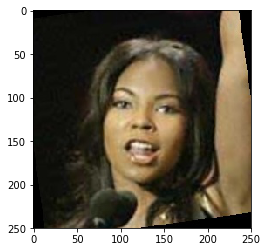

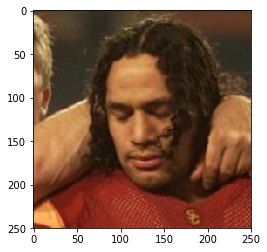

In [20]:
# make prediction
idx1 = 2
idx2 = 24
plt.figure()
plt.imshow(data_train[idx1][2]/255)
plt.figure()
plt.imshow(data_train[idx2][2]/255)
model.predict(x=[data_train[idx1][2].reshape(1,250,250,3), data_train[idx2][2].reshape(1,250,250,3)] )

array([[0.75747776, 0.24252225]], dtype=float32)

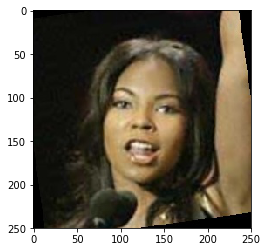

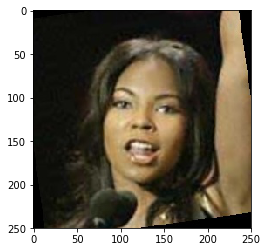

In [21]:
# make prediction
idx1 = 2
idx2 = 2
plt.figure()
plt.imshow(data_train[idx1][2]/255)
plt.figure()
plt.imshow(data_train[idx2][2]/255)
model.predict(x=[data_train[idx1][2].reshape(1,250,250,3), data_train[idx2][2].reshape(1,250,250,3)] )

In [22]:
# TODO: try one shot learning. Only use 1 image per person for training
# TODO: Use randomly cropped, rotated, etc images to improve generalization
# TODO: try Resnet-like architecture